This notebook shows how the `POD` class can be used to perform the Proper Orthogonal Decomposition on a data set of two-dimensional Rayleigh-Bénard convection.

---

### 1. Data Specifications 

The flow data was obtained by means of a direct numerical simulation (DNS) using the spectral element solver Nek5000 (https://github.com/Nek5000/Nek5000).

The data comprises the horizontal and vertical velocity fields $(u_x(x,y),u_z(x,y))^T$ as well as the temperature field $T(x,y)$. 

The RBC flow parameters were 
- Prandtl number $Pr = 10$
- Rayleigh number $Ra = 10^6$
- aspect ratio of the spatial domain: $\Gamma = L_x/H = 4$

The boundary conditions were:
- free slip for the horizontal velocity
- no-penetration for the vertical velocity
- constant temperature (Dirichlet)

The DNS fields are interpolated to a uniform grid of size $N_x \times N_y = 128 \times 32$. The total number of snapshots was $N_t = 10^4$. Their spacing is $0.25$ free fall times $H/U_f$.

Let's import the first 2000 snapshots of the RBC data $X\in \mathbb{R}^{N_t\times 3\cdot N_y\cdot N_x}$ and inspect it:

In [15]:
import numpy as np

data = np.load("data/RBC_A4Ra1e6Pr10_fs.npy")
data = data[:2000]
nt, nfields, ny, nx = data.shape

Text(0.5, 1.0, '$T(x,y)$')

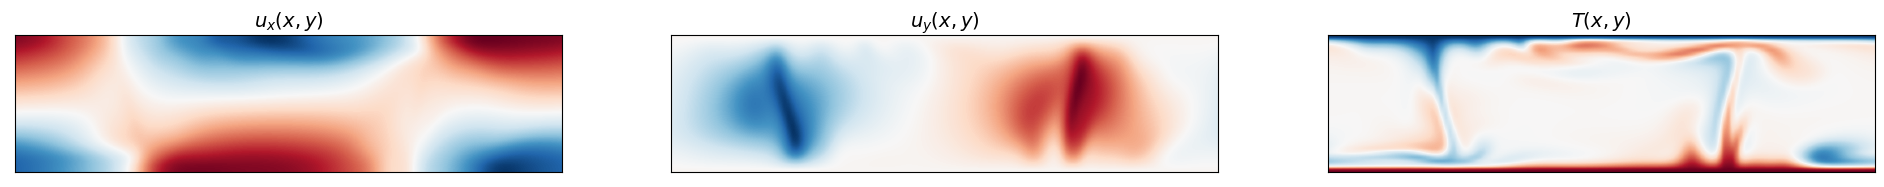

In [16]:
import matplotlib.pyplot as plt

it = 0  # which snapshot to show

fig,axs = plt.subplots(figsize=(8*3,2),ncols=3,nrows=1)
for ii,ifield in enumerate(range(nfields)):
    axs[ii].imshow(np.flip(data[it,ifield],axis=0),cmap="RdBu_r",interpolation="gaussian")
    
for iax in axs:
    iax.set_xticks([])
    iax.set_yticks([])
axs[0].set_title(r"$u_x(x,y)$",fontsize=14)
axs[1].set_title(r"$u_y(x,y)$",fontsize=14)
axs[2].set_title(r"$T(x,y)$",fontsize=14)

The goal of the POD is to obtain a set of a few modes that represent the main features of these three fields. For this, the covariance matrix of the RBC data is formed and its EVP is solved. 

### 2. Forming the covariance matrix 
In a first step the time mean is subtracted from the data $X$. If this step is not taken, the mean will appear in shape of the first POD mode and dominate the POD spectrum. Therefore the data fluctuations become
$$
\tilde{X} = X - \langle X \rangle_t
$$
and its covariance matrix is
$$
C = \frac{1}{N_t-1} \tilde{X}\tilde{X}^T \in \mathbb{R}^{N_t\times N_t}
$$
Note the normalization factor of $N_t-1$. Further, $C$ is a hermitian matrix.

In [62]:
# Form data matrix X
#---------------------
X = data.reshape(nt,-1)

# Subtract  time mean
#----------------------
time_mean = X.mean(axis=0,keepdims=True)
X = X - time_mean

# Compute covariance matrix
#--------------------------
C = 1/(nt-1)*X@X.T
C.shape

(2000, 2000)

In [63]:
time_mean.shape

(1, 12288)

### 3. Solving the eigenvalue problem (EVP) of $C$
$$
CA = A\Lambda
$$
As we have computed $C$ using the snapshot method, its eigenvectors are the POD time coefficients $a_k(t)$, stored in the matrix $A\in\mathbb{R}^{N_t \times N_{modes}}$. The eigenvalues $\lambda$ denote the contribution of the individual modes to the variance of the original data. They are stored in the diagonal matrix $\Lambda\in\mathbb{R}^{N_{modes}\times N_{modes}}$.

In [18]:
# Compute EVP / Perform POD
#-----------------------------
evals, time_coefficients = np.linalg.eigh(C)

# Sort according to descending eigenvalues (contribution to variance)
#-------------------------------------------------------------------
idx = np.argsort(evals)[::-1]
evals = evals[idx]
time_coefficients = time_coefficients[:,idx]

Let us inspect the POD spectrum, i.e., the contribution of each POD mode to the variance of $\tilde{X}$

Text(0, 0.5, 'Individual contribution to variance [%]')

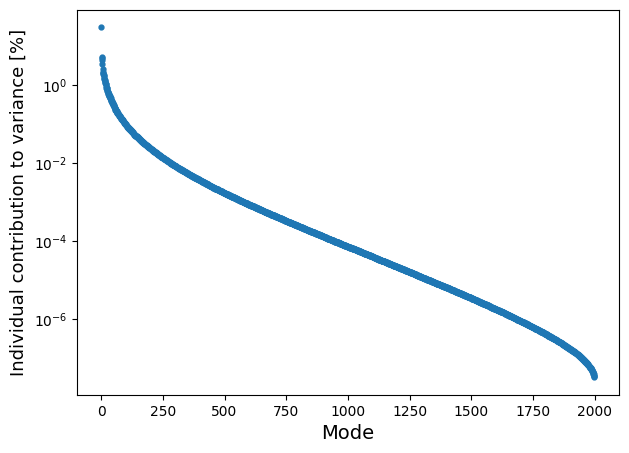

In [19]:
# Compute the POD spectrum
#--------------------------------------
pod_spectrum = evals/evals.sum()

# Plot spectrum
#--------------
fig,axs = plt.subplots(figsize=(7,5))
axs.semilogy(range(1,len(pod_spectrum)+1),pod_spectrum*100,marker=".",markersize=7,linewidth=0)
axs.set_xlabel("Mode",fontsize=14)
axs.set_ylabel("Individual contribution to variance [%]",fontsize=13)

It can be seen that the first mode captures already about 29.5% of the variance. After that the contributions decay quickly.

In [20]:
pod_spectrum[0:3]

array([0.2946405 , 0.05220433, 0.04867699], dtype=float32)

Let us inspect the time coefficents $a_k(t)$:

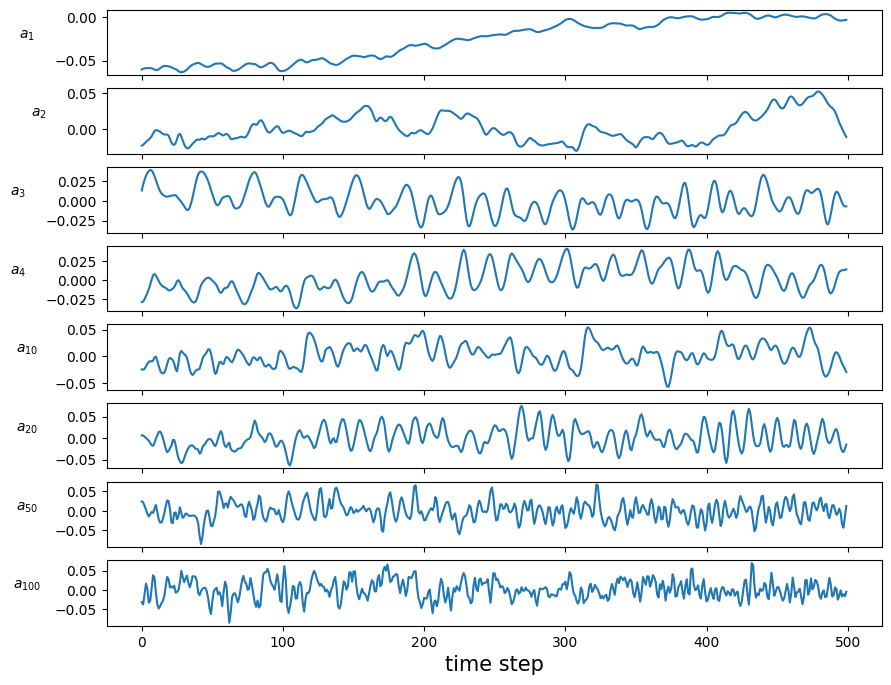

In [37]:
# Plot time coefficents 
#-------------------------
modes = [0,1,2,3,9,19,49,99]
fig,axs = plt.subplots(figsize=(10,8),nrows=8,sharex=True)

for ii,imode in enumerate(modes):
    axs[ii].plot(time_coefficients[:500,imode])
    axs[ii].set_ylabel(r"$a_{"+f"{imode+1}"+r"}$",rotation=0,labelpad=20)
    
axs[-1].set_xlabel("time step",fontsize=15)
for iax in axs:
    pass
    #iax.set_ylim([-0.05,0.05])

### 4. Compute POD spatial modes
The POD spatial modes $\phi_k(x,y)$ are obtained by projecting the original data set onto the time coefficients
$$
 \Phi = \tilde{X}^T A \in \mathbb{R}^{3N_zN_yN_x \times N_{modes}}.
$$
Note that the each physical field has its own spatial mode, while the time coefficients are shared by all three fields.

In [22]:
# Compute spatial modes
#---------------------------
spatial_modes = X.T@time_coefficients

# Reshape into correct order
#----------------------------
spatial_modes = spatial_modes.reshape(3,ny,nx,-1)

Let us inspect the spatial modes $\phi_k(x,y)$  to the time coefficients $a_k(t)$

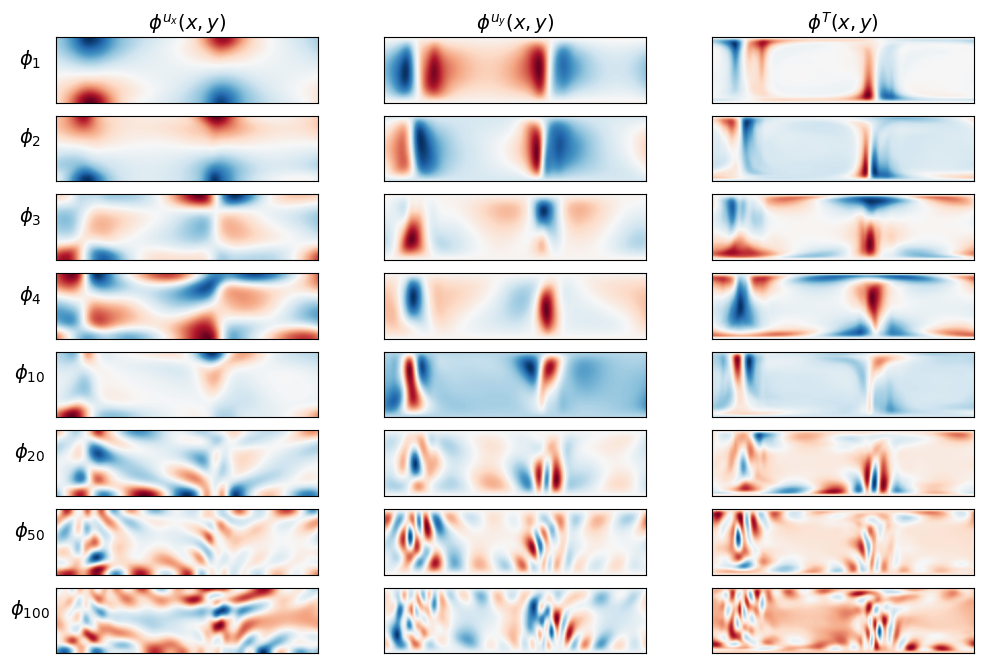

In [40]:
fig,axs = plt.subplots(figsize=(4*3,len(modes)),ncols=3,nrows=len(modes))
for jj,ifield in enumerate(range(3)):
    for ii,imode in enumerate(modes):
        axs[ii,jj].imshow(np.flip(spatial_modes[ifield,:,:,imode],axis=0),cmap="RdBu_r",interpolation="gaussian")
        axs[ii,0].set_ylabel(r"$\phi_{"+f"{imode+1}"+r"}$",fontsize=14,rotation=0,labelpad=15)
        
for iax in axs.flatten():
    iax.set_xticks([])
    iax.set_yticks([])
    
axs[0,0].set_title(r"$\phi^{u_x}(x,y)$",fontsize=14)
axs[0,1].set_title(r"$\phi^{u_y}(x,y)$",fontsize=14)
axs[0,2].set_title(r"$\phi^{T}(x,y)$",fontsize=14);

### 5. Building a Reduced Order Model (ROM) of the RBC flow
We can now easily build a ROM of the flow, by considering a subset of $N_{\rm POD}\ll 2000$ POD modes. For this one should set a threshold for how much variance one wants to capture with the ROM. A reasonable threshold might be $75\%$. In the present case this corresponds to $N_{\rm POD}\approx 28$ (see cell below).

In [71]:
npod = 28
pod_spectrum[:npod].sum()*100

75.38339495658875

The ROM then only considers $a_1(t), a_2(t), ..., a_{28}(t)$ and $\phi_1(x,y), \phi_2(x,y), ..., \phi_{28}(x,y)$. Bases on these values the ROM flow can be reconstructed via
$$
\hat{X} = \hat{\Phi}\hat{A}^T
$$
where the hat symbol denotes the ROM values.

In [73]:
# Reconstruct flow from N_POD = 28 modes
#----------------------------------------
X_ROM = spatial_modes[:,:,:,:npod]@time_coefficients[:,:npod].T

# Add time_mean
#---------------
X_ROM += time_mean.reshape(3,ny,nx,1)

Text(0.5, 1.0, '$T(x,y)$')

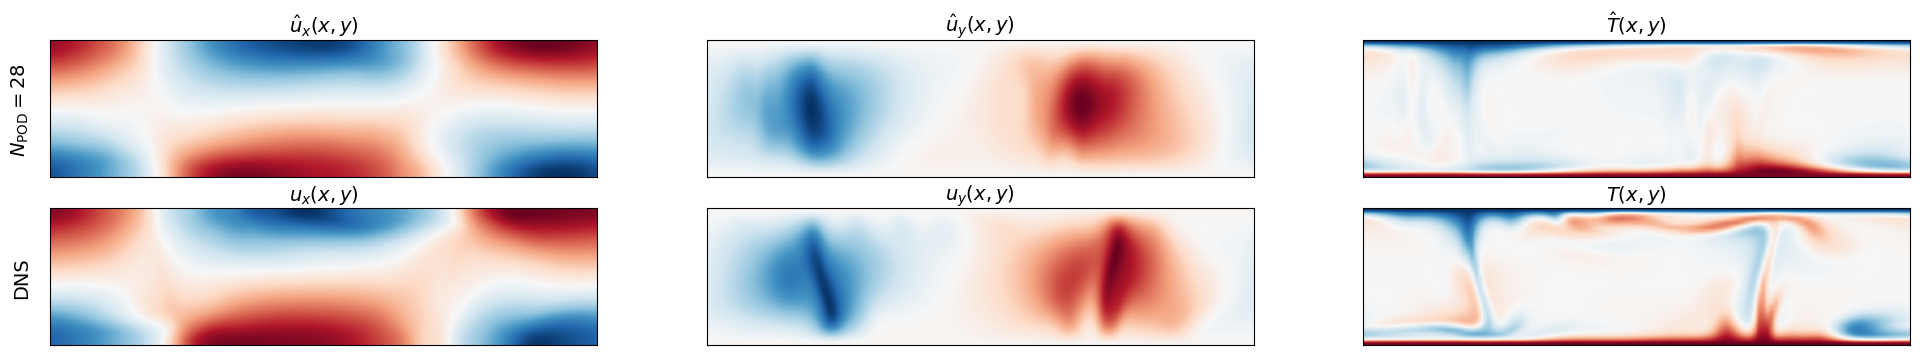

In [79]:
it = 0  # which snapshot to show

fig,axs = plt.subplots(figsize=(8*3,2*2),ncols=3,nrows=2)
for ii,ifield in enumerate(range(nfields)):
    axs[0,ii].imshow(np.flip(X_ROM[ifield,:,:,it],axis=0),cmap="RdBu_r",interpolation="gaussian")
    axs[1,ii].imshow(np.flip(data[it,ifield,:,:],axis=0),cmap="RdBu_r",interpolation="gaussian")
    
    

for iax in axs.flatten():
    iax.set_xticks([])
    iax.set_yticks([])
    
axs[0,0].set_ylabel(r"$N_{\rm POD}=$" + f"{npod}",labelpad=10,fontsize=14)
axs[1,0].set_ylabel("DNS",labelpad=10,fontsize=14)

axs[0,0].set_title(r"$\hat{u}_x(x,y)$",fontsize=14)
axs[0,1].set_title(r"$\hat{u}_y(x,y)$",fontsize=14)
axs[0,2].set_title(r"$\hat{T}(x,y)$",fontsize=14)

axs[1,0].set_title(r"$u_x(x,y)$",fontsize=14)
axs[1,1].set_title(r"$u_y(x,y)$",fontsize=14)
axs[1,2].set_title(r"$T(x,y)$",fontsize=14)

It can be seen that the first $28$ POD modes capture the main features of the flow. However, fine-scale features are discarded, as they are captured by higher-order modes. 

---

The `POD` class in the `pod_class.py` script contains utilities for performing the POD procedure. Further, it saves the POD modes and time coefficients to a `hdf5` file from which the results can easily be loaded for further use. For larger datasets, you may want to use an HPC cluster. For this, you may submit a batch job which runs the `run_pod.py` script.